In [1]:
import qaoa
import qucompsys as qucs
import graphs as gr
import qutip as qu
import numpy as np
import matplotlib.pyplot as plt
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
import networkx as nx
from   networkx.generators.random_graphs import erdos_renyi_graph
import configparser
import scipy
import itertools
from collections import Counter

%matplotlib inline
%config InlineBackened.figure_format = 'svg'

# Apply QAOA for MaxCut problem:

here we're going to implement the general QAOA approach for a specific CSP problem, using the SGD method for parameters optimization,the steps are:

* define the problem and the specific object is referred to (which gives also $C$)
* parameter optimization:<br>
    * choose QAOA-level = p and pick p-pairs parameters $(\gamma_1,...,\gamma_p,\beta_1,...,\beta_p)_0$<br>
    * generate initial state $|s\rangle$ (usually is chosen to be easy to be prepeared) (which gives also $B$)<br>
    * evolve $|s\rangle$ in $|\vec{\gamma},\vec{\beta}\rangle$ through 2p evolutions<br>
    * evaluate $F_p$ (or only certain terms of it) through N-times computational basis measurement on $|\vec{\gamma},\vec{\beta}\rangle$, obtained as the "classical" meanvalue of the N-outcomes
    * update the parameters<br>
    different methods may be implemented for parameters update, here we're going to see:
        * grid search <br>
        * $0^{th}$-order SGD method (_finite differencies_) (perform it M-times/until $- \nabla F_p(\vec{\gamma},\vec{\beta}) \approx 0$/...)<br>
        * $1^{st}$-order SGD method (_doubly SGD_) (perform it M-times/until $- \nabla F_p(\vec{\gamma},\vec{\beta}) \approx 0$/...)<br>        
* $(\vec{\gamma},\vec{\beta})$ which optimize $F_p$ will be obtained after these iterations (and the solutions to the problem could be seen from frequencies of strings obtained in the computational basis measurement for these angles)

A.1 special case: 1-level QAOA for MaxCut

* get information of the graph
* parameter optimization:
    * evaluate analitical exspression of $F_1(\gamma, \beta)$ from graph informations
    * maximization may be computed through:
        * grid search
        * scipy built-in function
        * other methods ...
* optimal $(\gamma, \beta)$ will the ones that maximize $F_1$

##  0 Define the graph

**method_1**: define manually graphs

In [2]:
#house
n_nodes = 5
nodes = np.arange(0, n_nodes, 1)
edges = [(0,1),(1,2),(1,4),(0,4),(2,3),(3,4)]

In [3]:
n_qubits = n_nodes
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
edges = list(graph.edges)

**method_2**: take information from files

**method_3**: generate random graph

### 0.1 plot the graph

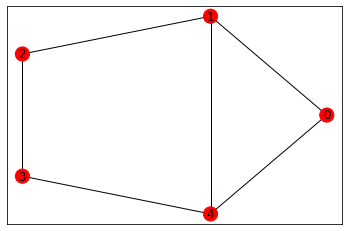

In [4]:
colors = ['r' for node in graph.nodes()]
pos = nx.circular_layout(graph)
graph_drawing = nx.draw_networkx(graph, node_color=colors, node_size=200, alpha=1, pos=pos, with_labels=True)
plt.show()

### 0.2 Find maximum cuts by checking all possible configurations

Define objective function
$$C(z) = \sum_{\alpha = 1}^{m}C_{\alpha}(z),$$
with $C_{\alpha} = \frac{1}{2}(z_u - z_v)$, where $\alpha = \, <u,v> \, \in \, \{<u,v>\} = E$, set of all edges 

Obtain a list of all possible configurations (as bit strings)

In [5]:
def find_maximum_cuts (n_qubits, edges):
    configurations = []
    for i in range(2**(n_qubits-1)):
        configurations.append(bin(i)[2:].zfill(n_qubits))
    dict_cuts = {}
    for config in configurations:
        dict_cuts[config] = qaoa.evaluate_cost_fun(config, edges)
    max_cost_fun = max(list(dict_cuts.values()))
    maximum_cuts = []
    for key in dict_cuts.keys():
        if dict_cuts[key] == max_cost_fun:
            maximum_cuts.append(key)
    return maximum_cuts

In [6]:
find_maximum_cuts(n_qubits, edges)

['00101', '01010']

In [7]:
a_maximum_cut = find_maximum_cuts(n_qubits, edges)[0]
max_cost_fun = qaoa.evaluate_cost_fun (a_maximum_cut, edges)
max_cost_fun

5

In [8]:
configurations = list(itertools.product([0,1], repeat = n_qubits))
dict_cuts = {}
for i in range(2**(n_qubits-1)):
    dict_cuts[configurations[i]] = qaoa.evaluate_cost_fun(configurations[i], edges)

In [9]:
#print frquencies of cuts 
print(np.unique(list(dict_cuts.values()), return_counts = True))

(array([0, 2, 3, 4, 5]), array([1, 4, 6, 3, 2], dtype=int64))


{(0, 0, 1, 0, 1): 5, (0, 1, 0, 1, 0): 5}


(array([1., 0., 0., 0., 4., 0., 6., 0., 3., 2.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

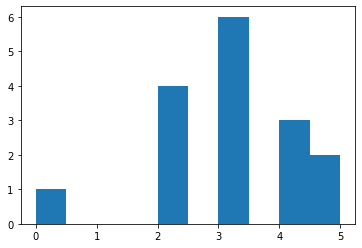

In [10]:
dict_max_cuts = dict((config, max_cut) for config, max_cut in dict_cuts.items() if max_cut == np.max(list(dict_cuts.values())))
print(dict_max_cuts)
plt.hist(dict_cuts.values())

In [11]:
list(dict_max_cuts.keys())

[(0, 0, 1, 0, 1), (0, 1, 0, 1, 0)]

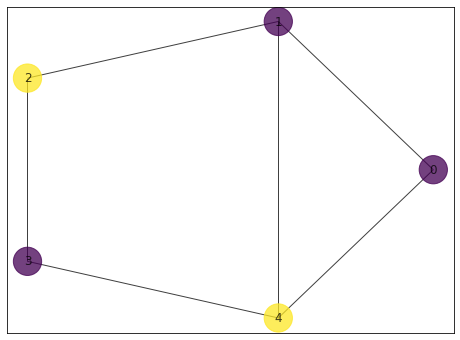

In [12]:
#print one max_cut
fig = plt.figure(figsize=(8,6))
colors = list(dict_max_cuts.keys())[0]
pos = nx.circular_layout(graph)
nx.draw_networkx(graph, node_color=colors, node_size=800, alpha = 0.75, pos=pos)

## 1 Parameters optimization

## 1.1 Choose QAOA level and pick initial parameters

In [13]:
n_levels = 1

In [14]:
list_init_params = 0.5*np.random.rand(2*n_levels)
list_init_gammas = list_init_params[:n_levels]
list_init_betas = list_init_params[n_levels:]

## 1.2 Generate initial state

${\large |s\rangle = \sum_{z \, \in \, \{0,1\}^n}^{}{|z\rangle} = |+\rangle^{\otimes n}}$

In [24]:
# initial state:
init_state = qaoa.initial_state(n_qubits)
dm_init_state = qu.ket2dm(qaoa.initial_state(n_qubits))

In [26]:
len(init_state.dims[0])

5

In [27]:
len(dm_init_state.dims[0])

5

## 1.3 Obtain final state

${\large |\vec{\gamma},\vec{\beta}\rangle = U(B,\beta_p)U(C,\gamma_p)...U(B,\beta_1)U(C,\gamma_1)|s\rangle}$

In [20]:
# obtain final state:
optimal_params = optimal_params_scipy
#optimal_params = optimal_parameters_Adam_fin_diff
optimal_gammas = optimal_params[:n_levels]
optimal_betas = optimal_params[n_levels:]
fin_state = qaoa.evolution_operator(n_qubits, edges, optimal_gammas, optimal_betas)*init_state
#dm_fin_state = qaoa.evolution_operator(n_qubits, edges, optimal_gammas, optimal_betas)*dm_init_state*qaoa.evolution_operator(n_qubits, edges, optimal_gammas, optimal_betas).dag()

##  1.4 Perform N-computational_basis measurements on $|\vec{\gamma},\vec{\beta}\rangle$ and evaluate $F_p$

the idea is that, for each ($\gamma,\beta$), after each measurement I will obtain as outcome one of the elements of the computational basis: $\{z : z \in \{ 0,1 \}^n\}$

so, after N measurements, I will have each that each possible outcome $z_i$ has been obtained with occurency $w_i$, so $F_p$ will be evaluated as:

$$F_p = \frac{\sum_{i}^{N}{w_iC(z_i)}}{\sum_{i}^{N}{w_i}}$$

In [23]:
n_samples = 100
optimal_params = optimal_params_scipy
#optimal_params = optimal_parameters_Adam_fin_diff
F_p= qaoa.evaluate_F_p(optimal_params, n_qubits, edges,  n_samples)
F_p

TypeError: '<=' not supported between instances of 'float' and 'complex'

In [169]:
occurrencies = Counter(qucs.quantum_measurements(n_samples, dm_fin_state))

<BarContainer object of 30 artists>

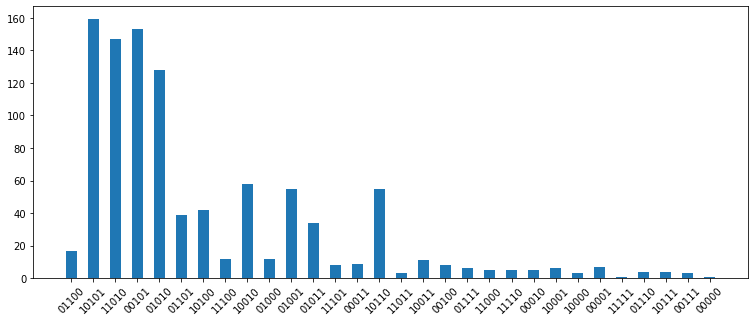

In [170]:
# plot probabilities of each state of the graph corresponding to every possible configuration after a cut
plt.figure(figsize = (2**n_qubits/2.5,5))
plt.xticks(rotation=45)
plt.bar(occurrencies.keys(),occurrencies.values(),width = 0.5)

## 1.5 Parameter update

### 1.5.1 Grid search method

The idea is that $F_p$ is evaluated for each combination of values in a $2p$-dimensional space

In [35]:
step_size = 0.2
a_gammas         = np.arange(0, np.pi, step_size)
a_betas          = np.arange(0, np.pi/2, step_size)
grid_gammas_betas = list(itertools.product(a_gammas, a_betas, repeat=n_levels))
grid_F_p = []
for par in grid_gammas_betas:
    grid_F_p.append(qaoa.evaluate_F_p(np.reshape(par, (2,1)), n_qubits, edges, 100))

In [24]:
optimal_gamma_grid   = grid_gammas_betas[grid_F_p.index(max(grid_F_p))][0]
optimal_beta_grid  = grid_gammas_betas[grid_F_p.index(max(grid_F_p))][1]

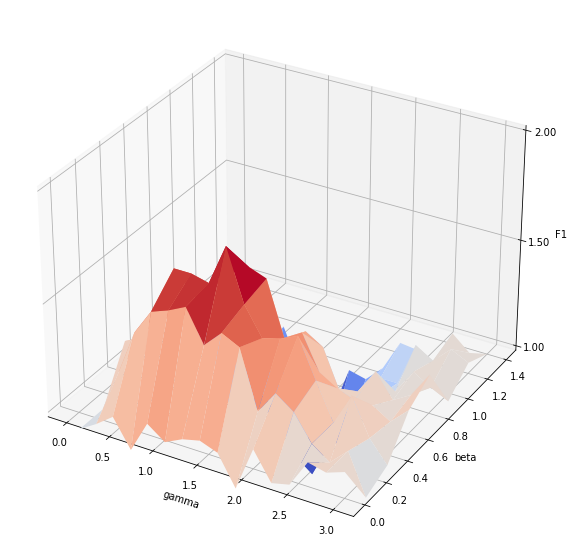


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  F_1 = 1.710
where the max_C is  2
This is attained for gamma = 1.200 and beta = 0.400


In [25]:
# Plot the expetation value grid_f_1
fig = plt.figure(figsize = (10,10))
ax  = fig.gca(projection='3d')

y_axis, x_axis = np.meshgrid(a_betas, a_gammas)
z_axis = np.reshape(np.array(grid_F_p), y_axis.shape)
surf = ax.plot_surface(x_axis, y_axis, z_axis, cmap=cm.coolwarm, linewidth=0, antialiased=True)

a_maximum_cut = find_maximum_cuts(n_qubits, edges)[0]
max_cost_fun = qaoa.evaluate_cost_fun (a_maximum_cut, edges)
max_cost_fun
ax.set_zlim(1,max_cost_fun)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_ylabel('beta')
ax.set_xlabel('gamma')
ax.set_zlabel('F1')

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  F_1 = %.03f' % np.amax(z_axis))
print('where the max_C is ', max_cost_fun)
print('This is attained for gamma = %.03f and beta = %.03f' % (optimal_gamma_grid, optimal_beta_grid))

### 1.5.2 SGD methods

at $t$-th parameters choice, with parameters $\vec{\theta}^{(t)} = (\gamma_1,...,\gamma_p,\beta_1,...,\beta_p)_k$, 
the next parameters $\vec{\theta}^{(t+1)} = (\gamma_1,...,\gamma_p,\beta_1,...,\beta_p)^{(t+1)}$ are obtained through:
* evalutating the descent step $\eta^{(t)}$ (here we can start with the stationary case where $\theta^{(t)} = \bar{\eta} = constant$)
* estimate the slope direction $\vec{g}(\vec{\theta}^{(t)}) := - \nabla F(\vec{\theta}^{(t)})$
* $\vec{\theta}^{(t+1)} = \vec{\theta}^{(t)} + \eta^{(t)} \vec{g}(\vec{\theta}^{(t)})$

#### 1.5.2.1 **Evaluate $\eta^{(t)}$**

**method 1**: $\eta = \bar{\eta} = constant$

**method 2**: Adagrad method

**method 3**: Adam method

#### 1.5.2.2 estimate the gradient $\vec{g}(\vec{\theta}^{(t)}) := - \nabla F(\vec{\theta}^{(t)})$

**method 1** $0^{th}$-order SGD method: finite differences

 $ \nabla F_p (\vec{\theta}) = \begin{bmatrix}
\frac{\partial F}{\partial \theta_1}\\
\vdots\\
\frac{\partial F}{\partial \theta_2p}
\end{bmatrix}$,
here each partial derivative $\frac{\partial F}{\partial \theta_i}$ will be evaluated with the _finite differences method_:

**Finite difference method**:

There are 3 main _difference formulas_ for numerically approximating derivatives:<br><br>
* the _forward difference formula_ with step size $h$ is <br>
    $$f'(a) \approx \frac{f(a+h)-f(a)}{h}$$ <br>
* the _backward difference formula_ with step size $h$ is <br>
    $$f'(a) \approx \frac{f(a)-f(a-h)}{h}$$ <br>
* The _central difference formula_ with step size  is the average of the forward and backwards difference formulas <br>
    $$f'(a) \approx \frac{f(a+h)-f(a-h)}{2h}$$

we're going to use the central method:

for a multivariable function $F(\vec{\theta})$, $\large \frac{\partial F}{\partial \theta_i} = \frac{F(\vec{\theta} + h\vec{e}_i) - F(\vec{\theta} - h\vec{e}_i)}{2h}$, with $\vec{e}_i$ $i$-th element of the standard basis    

In [18]:
#Define a function that evaluate the gradient estimator g_t
def fin_diff_grad(function, params, args=(), increment=0.01):
    """
    This method estimates the gradient of a function through finite
    differences method

    Parameters
    ----------
    function: function
        function of which the gradient has to be evaluated
    params : 1-D array like
        array of parameters of the function.
    args_fun : tuple
        optional arguments that the function may need. default = 0.01
    increment: float
        increment that define the finite differences method. default = 0.01

    Returns
    -------
    g_t: 1-D array
        array representing the gradient of the function in that parameters-space point

    """
    if not isinstance(args, tuple):
        args = (args,)
    d = len(list(params))
    a_params = np.array(params)
    g_t = np.zeros(d)
    for i in range(d):
        e_i = np.zeros(d)
        e_i[i] = 1.0
        g_t[i] = (function(a_params+e_i*increment, *args)-function(a_params-e_i*increment, *args))/(2*increment)
    return g_t

**method 1: $\eta = const$**

In [162]:
# perform M-steps for expectation value of the cost-function
n_steps = 10
parameters = np.array(list_init_params)
eta = 0.01
for i in range(n_steps):
    parameters = parameters + eta*fin_diff_grad(qaoa.evaluate_F_p, parameters, args=(n_qubits, edges, 100), increment=0.1)
    if (i + 1) % 1 == 0:
            print('in', parameters, "objective after step {:5d}: {: .7f}".format(i + 1, analitic_F_1(parameters, graph, edges)))
optimal_parameters = parameters
print('optimal parameters are ', optimal_parameters)

in [0.33201172 0.3292784 ] objective after step     1:  3.8704143
in [0.34501172 0.3412784 ] objective after step     2:  3.9071663
in [0.37051172 0.3442784 ] objective after step     3:  3.9599193
in [0.39801172 0.3552784 ] objective after step     4:  4.0184610
in [0.41501172 0.3552784 ] objective after step     5:  4.0480867
in [0.43701172 0.3632784 ] objective after step     6:  4.0887370
in [0.45851172 0.3672784 ] objective after step     7:  4.1233677
in [0.45351172 0.3747784 ] objective after step     8:  4.1189122
in [0.46951172 0.3822784 ] objective after step     9:  4.1439851
in [0.48401172 0.3642784 ] objective after step    10:  4.1571659
optimal parameters are  [0.48401172 0.3642784 ]


In [109]:
optimal_parameters

array([-0.19604614, -0.19587658])

In [125]:
qaoa.evaluate_F_p(optimal_parameters, n_qubits, edges, 10)

1.1

**method 2: Adam**

![Adam algorithm](./images/AdamAlgorithm.PNG)

In [126]:
#perform it for analitical_F_1 (check if this method works properly for p=1 case)
n_steps = 30
parameters = np.array(list_init_params)
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-8
m_t = np.zeros(2*n_levels)
v_t = np.zeros(2*n_levels)
t = 0
eta = 0.01
for i in range(n_steps):
    g_t = fin_diff_grad(analitic_F_1, parameters, args=(graph, edges), increment=0.1)
    parameters = parameters + eta*g_t
    if (i + 1) % 5 == 0:
            print('in', parameters, "objective after step {:5d}: {: .7f}".format(i + 1, analitic_F_1(parameters, graph, edges)))
    t = t+1
    m_t = beta_1*m_t + (1-beta_1)*g_t
    v_t = beta_2*v_t + (1-beta_2)*g_t**2
    m_t_hat = m_t/(1-beta_1**t)
    v_t_hat = v_t/(1-beta_2**t)
    parameters = parameters + eta*m_t_hat/(np.sqrt(v_t_hat) + epsilon)
optimal_parameters_analitical = parameters
print('optimal parameters are ', optimal_parameters_analitical)

in [0.54846479 0.38644793] objective after step     5:  8.1253560
in [0.58944394 0.39992201] objective after step    10:  8.1304052
in [0.59560713 0.39628703] objective after step    15:  8.1299268
in [0.58866627 0.39378809] objective after step    20:  8.1313840
in [0.58184167 0.39291289] objective after step    25:  8.1320225
in [0.57913134 0.39270659] objective after step    30:  8.1320977
optimal parameters are  [0.5787465  0.39269368]


In [165]:
#perform it for exp_F_1 (check if this method works properly for p=1 case)
n_steps = 30
parameters = np.array(list_init_params)
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-8
m_t = np.zeros(2*n_levels)
v_t = np.zeros(2*n_levels)
t = 0
eta = 0.01
for i in range(n_steps):
    g_t = fin_diff_grad(qaoa.evaluate_F_p, parameters, args=(n_qubits, edges, 100), increment=0.1)
    parameters = parameters + eta*g_t
    if (i + 1) % 5 == 0:
            print('in', parameters, "objective after step {:5d}: {: .7f}".format(i + 1, analitic_F_1(parameters, graph, edges)))
    t = t+1
    m_t = beta_1*m_t + (1-beta_1)*g_t
    v_t = beta_2*v_t + (1-beta_2)*g_t**2
    m_t_hat = m_t/(1-beta_1**t)
    v_t_hat = v_t/(1-beta_2**t)
    parameters = parameters + eta*m_t_hat/(np.sqrt(v_t_hat) + epsilon)
optimal_parameters_Adam_fin_diff = parameters
print('optimal parameters are ', optimal_parameters_Adam_fin_diff)

in [0.07431627 0.48453342 0.19354499 0.32114851 0.34773471 0.00410575] objective after step     5:  3.2070238
in [0.11658524 0.54429823 0.19737227 0.30301253 0.29106894 0.05492714] objective after step    10:  3.2838329
in [0.17726832 0.57873178 0.17309763 0.27340069 0.2530739  0.07091561] objective after step    15:  3.3800901
in [0.22884173 0.62061103 0.15609553 0.28989145 0.21542607 0.08665382] objective after step    20:  3.4006406
in [0.28244839 0.62397456 0.18353738 0.32299656 0.17303931 0.09320319] objective after step    25:  3.4736303
in [0.33739361 0.63985679 0.18817275 0.38161506 0.17736752 0.10509144] objective after step    30:  3.5007230
optimal parameters are  [0.34325816 0.64144325 0.18928695 0.3877946  0.1761846  0.10576602]


**method 2** $1^{st}$-order SGD method: _doubly SGD_

**Doubly SGD method**:

each $\frac{\partial F}{\partial \theta_i}$ will be evaluated through the estimator $g_i(\vec{\theta}^{(t)})$

in the simplest case, for QAOA with $F = \sum_{j=1}^{m}\langle H_j^P \rangle$, where $j \in \{<u,v>\}, H_j^P = Z_uZ_v$, and 
$U(\vec{\theta}) = [(\prod_{r = 1}^{n}$ $e^{-i \theta_d H_r^B})(\prod_{j' = 1}^{m} e^{-i \theta_{d-1} H_{j'}^P}) ] \ldots [(\prod_{r = 1}^{n} e^{-i\theta_2 H_r^B})(\prod_{i' = 1}^{m} e^{-i\theta_1 H_{j'}^P}) ]$:

$g_i(\vec{\theta}^{(t)}) = 
\begin{cases} 
\sum_{j=1}^{m}\sum_{r=1}^{n} \sum_{k=1}^{K(H_r^B)}\epsilon_{k,i}(H_r^B)\tilde{h}_j^{(N)}(\vec{\theta}_{k,i,H_r^B}), & \mbox{if } i\mbox{ is even} \\ 
\sum_{j=1}^{m}\sum_{j'=1}^{n} \sum_{k=1}^{K(H_{j'}^P)}\epsilon_{k,i}(H_{j'}^P)\tilde{h}_j^{(N)}(\vec{\theta}_{k,i,H_{j'}^P}), & \mbox{if } i\mbox{ is odd} 
\end{cases}$,

where $\tilde{h}_j^{(N)}(\vec{\theta}_{k,i,H_r^B})$ is the N-shot measurement estimator of the observable $O_j$ ($\langle O_j \rangle$) and 
$\vec{\theta}_{k,i,H_r^B} = \vec{\theta} + c_{k,i}(H_r^B)\vec{e}_j$ (the same for $H_{j'}^{P}$)

these expressions came from the _parameter shift rule_ and to evaluate $g_i(\vec{\theta}^{(t)})$, we have to know the parameters $K, \epsilon_{k,j}, c_{k,j}$

in general, they depend on the gate the angle $\theta_j$ is parameterizing, in QAOA, we have two kind of gates:
* 1-qubit gates: $H_r^B = X_r$
* 2-qubit gates: $H_{j'}^P = Z_uZ_v = O_{j'}$

it can be shown that, for both gates:
* $K = 2, k \in \{1,2\}$ 
* $\epsilon_{k,i} = +\frac{1}{2}$ for $k=1$ or $-\frac{1}{2}$ for $k = 2, \forall i$
* $c_{k,i} = +\frac{\pi}{2}$ for $k=1$ or $-\frac{\pi}{2}$ for $k = 2, \forall i$

furthermore, at each t-step, we sample over the elements of the three sums, so for j-even case (it's the same idea for the j-odd case):

1. sample $j \in \{1, \ldots , m\}$ with $prob(j)= \frac{1}{m}$<br><br>
2. sample $r \in \{1, \ldots , n\}$ with $prob(r)= \frac{1}{n}$ (I will not need to sample this, because it's the same for each $r$)<br><br> 
3. sample $k \in \{1, \ldots , K\}$ with $prob(K)= \frac{1}{K}$<br><br>
4. evaluate $\langle O_j \rangle$ as $\tilde{h}_j^{(N)}(\vec{\theta}_{k,i}) = \frac{\sum_{l=1}^N w_l O_j(z_l)}{\sum_{l=1}^{N} w_l}$, where $z_l$ is the outcome of the l-th measurement of the observable $O_j$ on the state $|\vec{\theta}_{k,j}\rangle = |\vec{\theta} + c_{k,j}\vec{e}_j\rangle$<br><br>
5. $g_i(\vec{\theta}^{(t)})= mnK\epsilon_{k,i}\tilde{h}_j^{(N)}(\vec{\theta}_{k,i}^{(t)})$

In [ ]:
#Define a function that evaluate the gradient estimator g_t
def doubly_stoc_grad(function, params, args=(), increment=0.01):
    """
    This method estimates the gradient of a function through 
    doubly stochastic method

    Parameters
    ----------
    function: function
        function of which the gradient has to be evaluated
    params : 1-D array like
        array of parameters of the function.
    args_fun : tuple
        optional arguments that the function may need. default = 0.01
    increment: float
        increment that define the finite differences method. default = 0.01

    Returns
    -------
    g_t: 1-D array
        array representing the gradient of the function in that parameters-space point

    """
    if not isinstance(args, tuple):
        args = (args,)
    d = len(list(params))
    a_params = np.array(params)
    g_t = np.zeros(d)
    for i in range(d):
        e_i = np.zeros(d)
        e_i[i] = 1.0
        g_t[i] = (function(a_params+e_i*increment, *args)-function(a_params-e_i*increment, *args))/(2*increment)
    return g_t

## A.1 Parameters optimization for special case of p = 1

for p = 1 QAOA level, for MaxCut, there's a therorem that gives an analitical expression of $F_p$:

$$F_1(\gamma,\beta) = \langle C \rangle = \sum_{<u,v>} C_{<u,v>} = \sum_{<u,v>} 
\frac{1}{2} + \frac{1}{4} (sin4\beta sin2\gamma)(cos^{d_u}\gamma + cos^{d_v}\gamma) - \frac{1}{4}(sin^2\beta cos^{d_u + d_v - 2\lambda_{uv}}\gamma)(1-cos^{\lambda_{uv}}2\gamma)$$

so, for each edge $<u,v>$, we have to get:
* $d_u$: degree of vertex $u$ -1
* $d_v$: degree of vertex $v$ -1
* $\lambda_{uv}$: number common neighbours of vertices $u$ and $v$

### 3.1 define functions to get $F_1$

define function to get $d_u + 1$

define function to get $\lambda_{uv}$

find $F_1$ maxima

define function which evaluates $F_1(\gamma, \beta)$

In [15]:
def analitic_F_1(parameters, graph, edges):
    f_1 = 0
    gamma = parameters[0]
    beta = parameters[1]
    for edge in edges:
        degree_u = gr.node_degree(graph, edge[0])
        degree_v = gr.node_degree(graph, edge[1])
        lambda_uv = gr.common_neighbours(graph, edge[0], edge[1])
        c_uv = 0.5+0.25*np.sin(4*beta)*np.sin(gamma)*(np.cos(gamma)**(degree_u-1) + np.cos(gamma)**(degree_v-1))
        -0.25*np.sin(beta)**2*np.cos(gamma)**(degree_u+degree_v-2-2*lambda_uv)*(1-np.cos(2*gamma)**lambda_uv)
        f_1 += c_uv
    return f_1

In [16]:
def minus_F_1(parameters, graph, edges):
    f_1 = 0
    gamma = parameters[0]
    beta = parameters[1]
    for edge in edges:
        degree_u = gr.node_degree(graph, edge[0])
        degree_v = gr.node_degree(graph, edge[1])
        lambda_uv = gr.common_neighbours(graph, edge[0], edge[1])
        c_uv = 0.5+0.25*np.sin(4*beta)*np.sin(gamma)*(np.cos(gamma)**(degree_u-1) + np.cos(gamma)**(degree_v-1))
        -0.25*np.sin(beta)**2*np.cos(gamma)**(degree_u+degree_v-2-2*lambda_uv)*(1-np.cos(2*gamma)**lambda_uv)
        f_1 += c_uv
    return -f_1

find $(\gamma, \beta)$ which maximize $F_1$

**method 1**: Grid search for the minimizing paramenters

define grid of possible values of $(\gamma, \beta)$, with $\gamma \in [0,\pi]$ and $\beta \in [0,\pi]$ and step size = 0.1

**1) use meshgrid**

In [178]:
step_size = 0.01
a_gamma_mesh         = np.arange(0.0, np.pi, step_size)
a_beta_mesh          = np.arange(0.0, np.pi/2, step_size)
a_gamma_mesh, a_beta_mesh = np.meshgrid(a_gamma_mesh, a_beta_mesh, indexing='xy')
parameters_mesh = np.array([a_gamma_mesh, a_beta_mesh])

In [179]:
# Grid search for the maximizing variables
grid_F_1_mesh = analitic_F_1(parameters_mesh, graph, edges)
result_mesh = np.where(grid_F_1_mesh == np.amax(grid_F_1_mesh))
max_pos_mesh      = list(zip(result_mesh[0],result_mesh[1]))[0]

In [180]:
optimal_gamma_mesh   = max_pos_mesh[1]*step_size
optimal_beta_mesh  = max_pos_mesh[0]*step_size

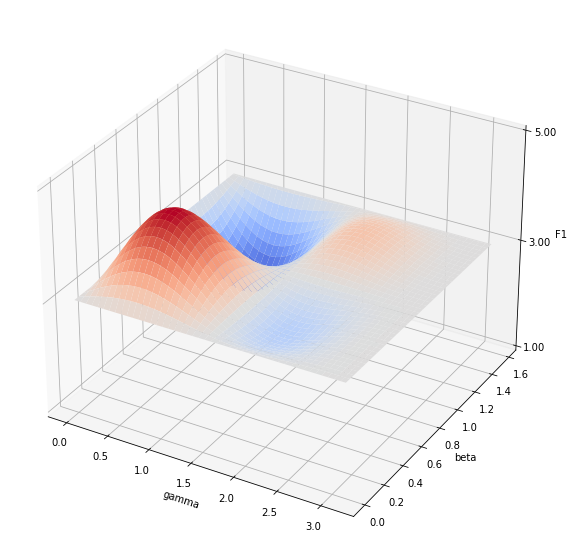


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  F_1 = 4.304
where the max_C is  5
This is attained for gamma = 0.700 and beta = 0.390


In [181]:
# Plot the expetation value grid_f_1
fig = plt.figure(figsize = (10,10))
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(parameters_mesh[0], parameters_mesh[1], grid_F_1_mesh, cmap=cm.coolwarm, linewidth=0, antialiased=True)

a_maximum_cut = find_maximum_cuts(n_qubits, edges)[0]
max_cost_fun = qaoa.evaluate_cost_fun (a_maximum_cut, edges)
ax.set_zlim(1,max_cost_fun)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_ylabel('beta')
ax.set_xlabel('gamma')
ax.set_zlabel('F1')

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  F_1 = %.03f' % np.amax(grid_F_1_mesh))
print('where the max_C is ', max_cost_fun)
print('This is attained for gamma = %.03f and beta = %.03f' % (optimal_gamma_mesh, optimal_beta_mesh))

**2) use itertools**

In [42]:
step_size = 0.01
a_gamma_iter         = np.arange(0, np.pi, step_size)
a_beta_iter          = np.arange(0, np.pi/2, step_size)
grid_gammas_betas_iter = list(itertools.product(a_gamma_iter, a_beta_iter))
grid_F_1_iter = []
for par_iter in grid_gammas_betas_iter:
    grid_F_1_iter.append(analitic_F_1(np.reshape(par_iter, (2,1)), graph, edges))

In [44]:
optimal_gamma_iter  = grid_gammas_betas_iter[grid_F_1_iter.index(max(grid_F_1_iter))][0]
optimal_beta_iter  = grid_gammas_betas_iter[grid_F_1_iter.index(max(grid_F_1_iter))][1]

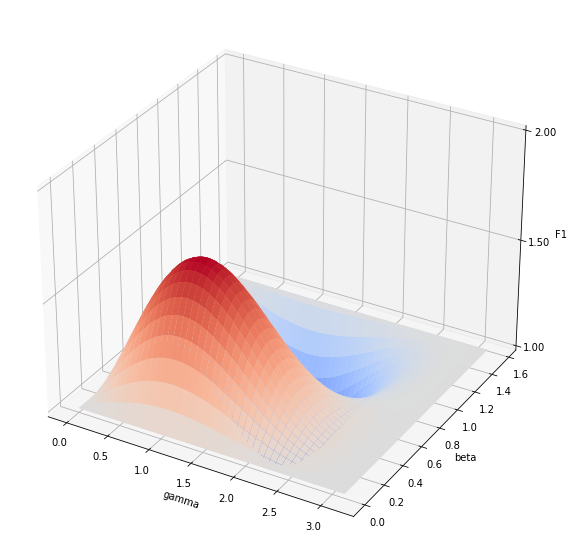


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  F_1 = 1.649
where the max_C is  2
This is attained for gamma = 1.050 and beta = 0.390


In [45]:
# Plot the expetation value grid_f_1
fig = plt.figure(figsize = (10,10))
ax  = fig.gca(projection='3d')


y_axis, x_axis = np.meshgrid(a_beta_iter, a_gamma_iter)
z_axis = np.reshape(np.array(grid_F_1_iter), y_axis.shape)
surf = ax.plot_surface(x_axis, y_axis, z_axis, cmap=cm.coolwarm, linewidth=0, antialiased=True)
surf = ax.plot_surface(x_axis, y_axis, z_axis, cmap=cm.coolwarm, linewidth=0, antialiased=True)

a_maximum_cut = find_maximum_cuts(n_qubits, edges)[0]
max_cost_fun = qaoa.evaluate_cost_fun (a_maximum_cut, edges)
max_cost_fun
ax.set_zlim(1,max_cost_fun)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_ylabel('beta')
ax.set_xlabel('gamma')
ax.set_zlabel('F1')

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  F_1 = %.03f' % np.amax(z_axis))
print('where the max_C is ', max_cost_fun)
print('This is attained for gamma = %.03f and beta = %.03f' % (optimal_gamma_iter, optimal_beta_iter))

**method 2**: use scipy built-in function

In [188]:
scipy.optimize.minimize(minus_F_1, [0.0, 0.0], args = (graph, edges), method='Nelder-Mead')

 final_simplex: (array([[0.69573323, 0.39266835],
       [0.69565416, 0.39270949],
       [0.69582684, 0.39271846]]), array([-4.30442848, -4.30442848, -4.30442845]))
           fun: -4.304428482144781
       message: 'Optimization terminated successfully.'
          nfev: 133
           nit: 68
        status: 0
       success: True
             x: array([0.69573323, 0.39266835])

In [18]:
optimal_params_scipy = scipy.optimize.minimize(minus_F_1, [0.0, 0.0], args = (graph, edges), method='Nelder-Mead')['x']
optimal_gamma_scipy = optimal_params_scipy[0]
optimal_beta_scipy = optimal_params_scipy[1]

Plot function in parameaters space

### 3) evalaute final state through projective measurment on computational basis

In [23]:
# initial state (as density matrix):
init_state = qaoa.initial_state(n_qubits)
dm_init_state = qu.ket2dm(init_state)

In [24]:
# define MaxCut hamiltonian operators
mix_ham = qaoa.mix_hamilt(n_qubits)
prob_ham = qaoa.prob_hamilt(n_qubits, edges)

In [25]:
# obtain final state (as density matrix)
fin_state = qaoa.evolution_operator(n_qubits, edges, [optimal_gamma], [optimal_beta])*init_state
dm_fin_state = qu.ket2dm(fin_state)

In [41]:
fin_state

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1]], shape = (128, 1), type = ket
Qobj data =
[[-0.01117631-0.01305005j]
 [ 0.01507664-0.03476492j]
 [ 0.01666363-0.05924318j]
 [ 0.01587424-0.03246269j]
 [ 0.01507664-0.03476492j]
 [-0.00069304-0.07543023j]
 [ 0.01587424-0.03246269j]
 [-0.01380978-0.01362636j]
 [ 0.01104658-0.06456035j]
 [ 0.02279376-0.05495708j]
 [ 0.03904576-0.02761862j]
 [ 0.05535204+0.05263089j]
 [ 0.02279376-0.05495708j]
 [ 0.03680132+0.00553147j]
 [ 0.05535204+0.05263089j]
 [ 0.04987948+0.07219709j]
 [ 0.03886187-0.03668862j]
 [ 0.03807248-0.00990813j]
 [ 0.08144091+0.00801438j]
 [ 0.00162071+0.02815028j]
 [ 0.03807248-0.00990813j]
 [ 0.00838846+0.0089282j ]
 [ 0.00162071+0.02815028j]
 [-0.02028668+0.0094406j ]
 [ 0.09669521-0.02204974j]
 [ 0.11300149+0.05819977j]
 [ 0.25009643+0.02612557j]
 [ 0.07783145+0.04913867j]
 [ 0.11300149+0.05819977j]
 [ 0.10752893+0.07776596j]
 [ 0.07783145+0.04913867j]
 [ 0.02468692-0.02229629j]
 [ 0.01705154-0.0676799j

In [50]:
def comp_basis_prob_dist(qstate):
    prob_dist = []
    for component in qstate.full():
        prob_dist.append(float(abs(component))**2)
    return prob_dist

In [53]:
prob_dist_fin_state = comp_basis_prob_dist(fin_state)

In [58]:
round(sum(prob_dist_fin_state),14)

1.0

<BarContainer object of 64 artists>

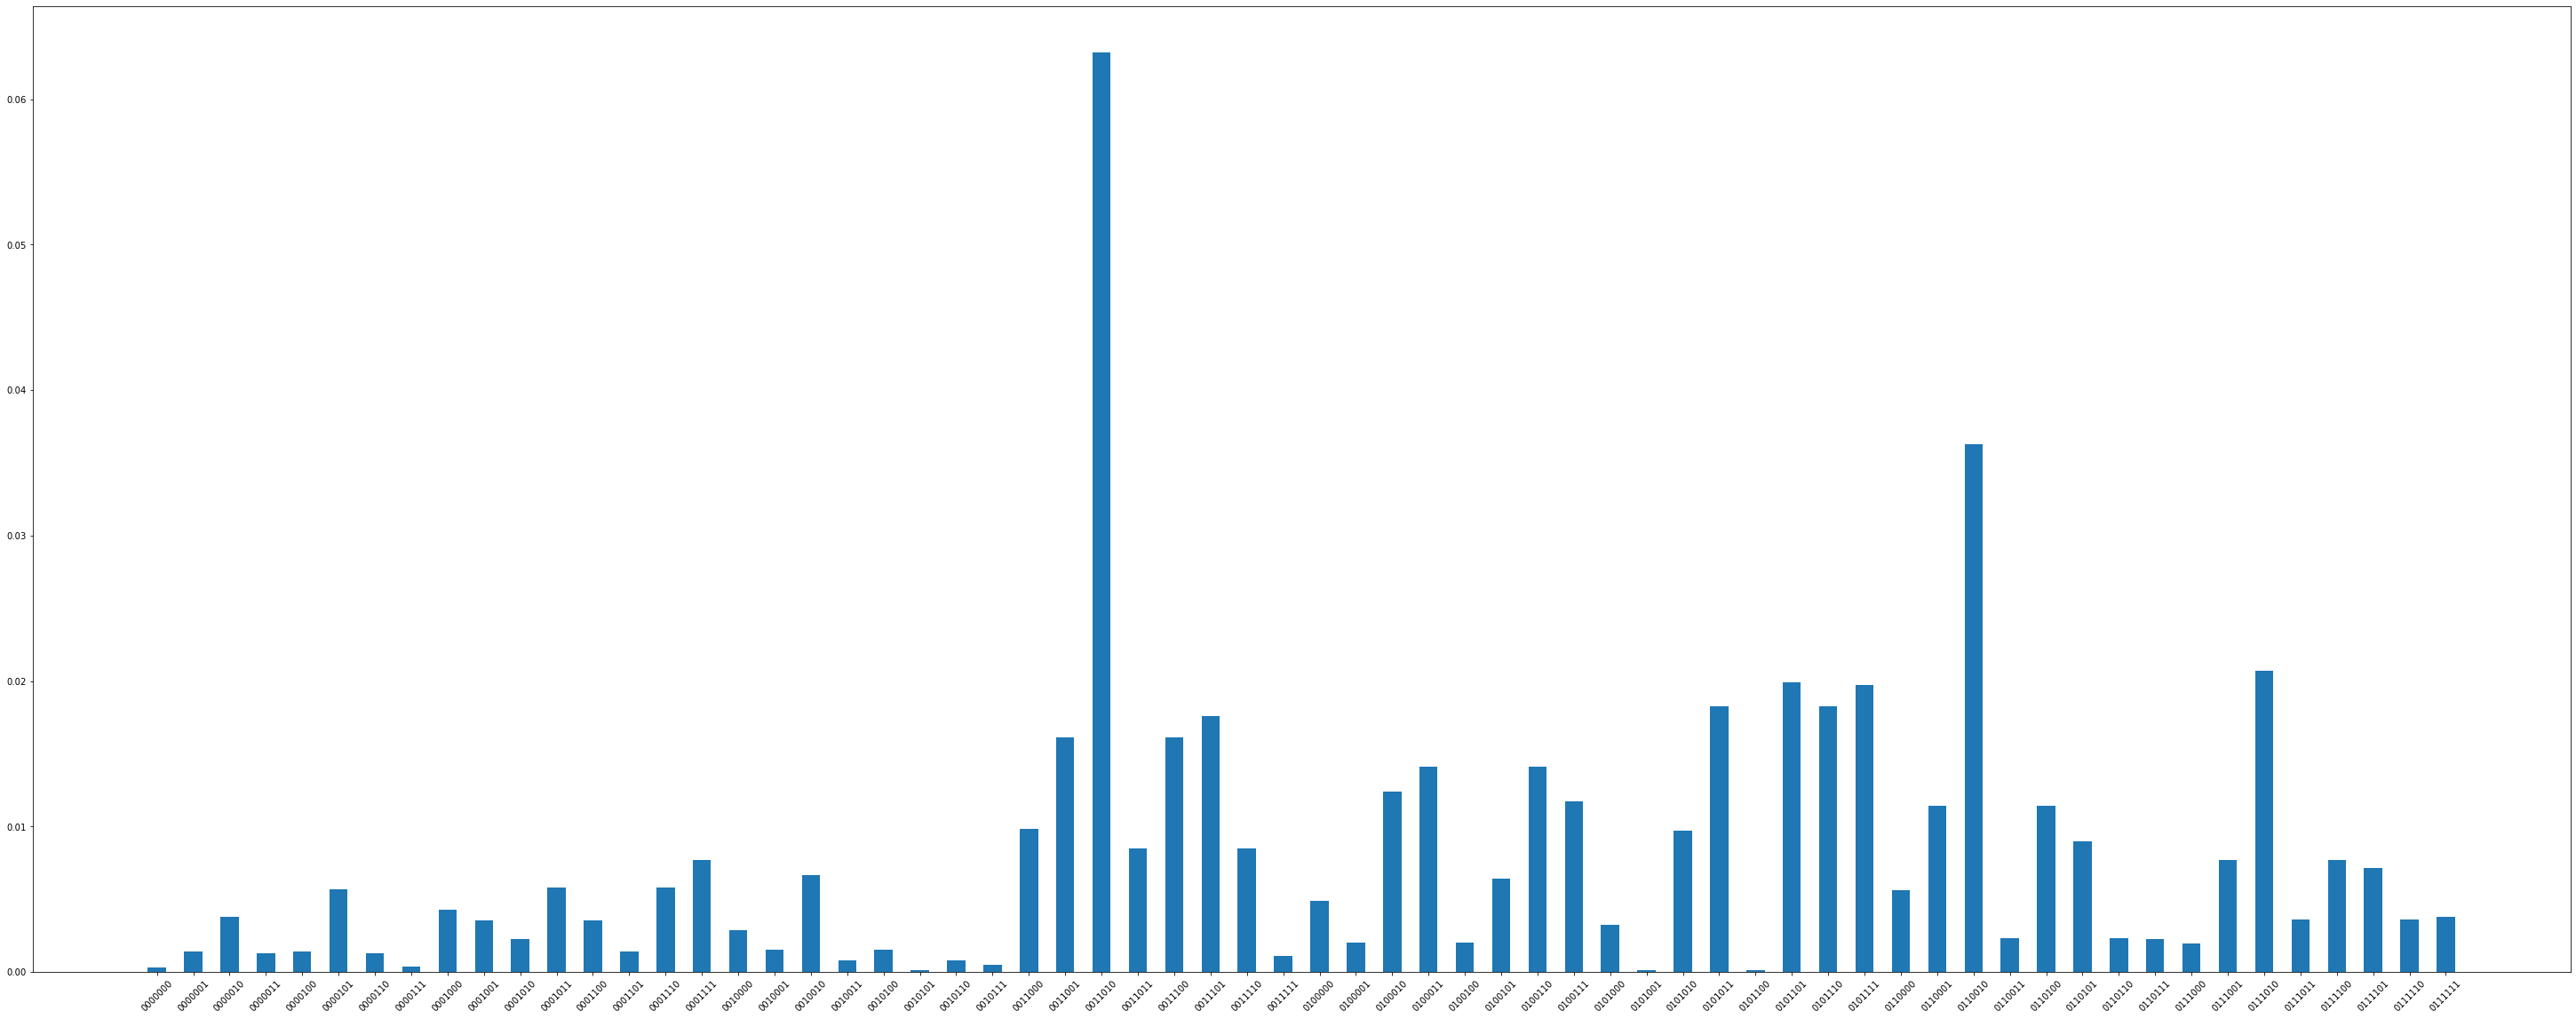

In [55]:
# plot probabilities of each state of the graph corresponding to every possible configuration after a cut (using the state)
plt.figure(figsize = (2**n_qubits/2.5,20))
plt.xticks(rotation=45)
xticks = range(0,2**(n_qubits-1))
xtick_labels = list(map(lambda x: format(x, "0"+str(n_qubits)+'b'), xticks))
plt.bar(xtick_labels,prob_dist_fin_state[:2**(n_qubits-1)],width = 0.5)

Check solutions

In [29]:
dict_prob = {}
for i in range(int(len(prob_dist_fin_state)/2)):
    dict_prob[bin(i)[2:].zfill(n_qubits)] = prob_dist_fin_state[i]

In [80]:
maximum_cuts = find_maximum_cuts(n_qubits, edges)
maximum_cuts

['011']

In [31]:
max_prob = sorted(list(dict_prob.values()))[-len(maximum_cuts):]

max_prob_states = []
for key in dict_prob.keys():
    for prob in max_prob:
        if dict_prob[key] == prob:
            max_prob_states.append(str(key))
            break

max_prob_states

['0011010']

In [32]:
maximum_cuts == max_prob_states

True

Test of the N measurements on single qubits of final state